# Отток клиентов

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

# Оглавление

* [Описание данных](#chapter0)
* [1. Подготовка данных](#chapter1)
* [2. Исследование задачи](#chapter2)
* [3. Борьба с дисбалансом](#chapter3)
    * [3.1. Взвешивание классов](#section_3_1)
    * [3.2. Увеличение выборки](#section_3_2)
    * [3.3. Изменение порога классификации](#section_3_3)
* [4. Тестирование моделей](#chapter4)
* [Итог](#chapter5)

# Описание данных <a class="anchor" id="chapter0"></a>

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import numpy as np
import timeit

In [2]:
df = pd.read_csv('datasets/Churn.csv')

In [3]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Признаки

- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — количество недвижимости у клиента
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

Целевой признак

- Exited — факт ухода клиента

# 1. Подготовка данных <a class="anchor" id="chapter2"></a>

Проанализируем общую информацию о датафрейме.

In [4]:
# Функция возвращает имя датафрейма
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

In [5]:
# Функция возвращает информацию по каждому датафрейму из списка.
def pre_check(df_list):
    for df in df_list:
        print('=================================')
        print(get_df_name(df))
        print('_________________________________')
        print(df.info())
        print('Количество дубликатов: ', df.duplicated().sum())
        print('_________________________________')

In [6]:
pre_check([df])

df
_________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None
Количество дубликатов:  0
__________________________

Чтобы обучить модель нам не понадобятся колонки 'RowNumber', 'CustomerId' и 'Surname'.

In [7]:
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

Предположим, что отсутствие значения связано с отсутствием недвижимости.

Заполним пропуски в колонке 'Tenure' значением `0`.

In [8]:
df['Tenure'] = df['Tenure'].fillna('0')

Преобразуем категориальные переменные методом прямого кодирования OHE (One-Hot Encoding), так как она работает со всеми моделями, в отличие от порядкового кодирования (Ordinal Encoding), которая не работает в случае логистической регрессии.

Чтобы не попасть в дамми-ловушку, воспользумся аргументом `drop_first=True`

In [9]:
data_ohe = pd.get_dummies(df, drop_first=True)

In [10]:
pre_check([data_ohe])

data_ohe
_________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  int64  
 1   Age                10000 non-null  int64  
 2   Balance            10000 non-null  float64
 3   NumOfProducts      10000 non-null  int64  
 4   HasCrCard          10000 non-null  int64  
 5   IsActiveMember     10000 non-null  int64  
 6   EstimatedSalary    10000 non-null  float64
 7   Exited             10000 non-null  int64  
 8   Geography_Germany  10000 non-null  uint8  
 9   Geography_Spain    10000 non-null  uint8  
 10  Gender_Male        10000 non-null  uint8  
 11  Tenure_1.0         10000 non-null  uint8  
 12  Tenure_2.0         10000 non-null  uint8  
 13  Tenure_3.0         10000 non-null  uint8  
 14  Tenure_4.0         10000 non-null  uint8  
 15  Tenure_5.0         10000 non

In [11]:
data_ohe.head()

,CreditScore,Age,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,...,Tenure_2.0,Tenure_3.0,Tenure_4.0,Tenure_5.0,Tenure_6.0,Tenure_7.0,Tenure_8.0,Tenure_9.0,Tenure_10.0,Tenure_0
0,619,42,0.00,1,1,1,101348.88,1,0,0,...,1,0,0,0,0,0,0,0,0,0
1,608,41,83807.86,1,0,1,112542.58,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,502,42,159660.80,3,1,0,113931.57,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,699,39,0.00,2,0,0,93826.63,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,850,43,125510.82,1,1,1,79084.10,0,0,1,...,1,0,0,0,0,0,0,0,0,0


Разделим датафрейм на цели и признаки.

In [12]:
target = data_ohe['Exited']
features = data_ohe.drop('Exited', axis=1)

Оценим баланс классов в исходном датасете.

In [17]:
target.value_counts()[1]/target.value_counts()[0]

0.25580811252040686

Баланс классов меньше 0.5, поэтому при разделении на выборки будем использовать стратификацию.
Разделим исходный датасет на обучающую и тестовую выборки, применив стратификацию.

In [19]:
"""
Функция возвращает обучающую, валидационную и тестовую выборки.
val_size - часть от исходной выборки
test_size - часть от исходной выборки
"""
def train_val_test_split(X, y, val_size=0.2, test_size=0.2, random_state=None):
    X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y) 
    
    val_size = val_size/(1-test_size)
    
    X_train, X_val, y_train, y_val = \
    train_test_split(X_train, y_train, test_size=val_size, random_state=random_state, stratify=y_train) # 0.25 x 0.8 = 0.2
    
    return (X_train, X_val, X_test, y_train, y_val, y_test)

Сохраним результат выполнения функции `train_val_test_split` в соответствующих переменных.

In [20]:
features_train, features_val, features_test, target_train, target_val, target_test = \
train_val_test_split(features, target, random_state=12345)

In [21]:
print('Соотношение:')
print('--> тренировка', round(features_train.shape[0] / df.shape[0], 2))
print('--> валидация', round(features_val.shape[0] / df.shape[0], 2))
print('--> тест', round(features_test.shape[0] / df.shape[0], 2))

Соотношение:
--> тренировка 0.6
--> валидация 0.2
--> тест 0.2


Проверим, что баланс классов в обучающей, валидационной и тестовой выборках приблизительно одинаковый:

In [22]:
target_train.value_counts()[1]/target_train.value_counts()[0]

0.25601842160351684

In [23]:
target_val.value_counts()[1]/target_val.value_counts()[0]

0.25549278091650973

In [24]:
target_test.value_counts()[1]/target_test.value_counts()[0]

0.25549278091650973

Отмасштабируем числовые признаки.

In [25]:
numeric = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [26]:
pd.options.mode.chained_assignment = None
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train.loc[:,numeric] = scaler.transform(features_train.loc[:,numeric])
features_val.loc[:,numeric] = scaler.transform(features_val.loc[:,numeric])
features_test.loc[:,numeric] = scaler.transform(features_test.loc[:,numeric])

In [27]:
features_train.head(2)

,CreditScore,Age,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,...,Tenure_2.0,Tenure_3.0,Tenure_4.0,Tenure_5.0,Tenure_6.0,Tenure_7.0,Tenure_8.0,Tenure_9.0,Tenure_10.0,Tenure_0
5536,-0.143332,0.577533,-1.220573,0.797767,1,1,1.029613,0,1,1,...,0,0,0,0,0,0,0,0,0,1
8530,1.632702,-0.564119,0.435807,-0.916018,1,0,0.237986,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [28]:
features_val.head(2)

,CreditScore,Age,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,...,Tenure_2.0,Tenure_3.0,Tenure_4.0,Tenure_5.0,Tenure_6.0,Tenure_7.0,Tenure_8.0,Tenure_9.0,Tenure_10.0,Tenure_0
9375,0.094161,0.862946,0.757050,0.797767,1,0,-0.308325,1,0,1,...,0,0,1,0,0,0,0,0,0,0
9536,-1.031349,0.292120,0.838881,-0.916018,1,0,-0.645029,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [29]:
features_test.head(2)

,CreditScore,Age,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,...,Tenure_2.0,Tenure_3.0,Tenure_4.0,Tenure_5.0,Tenure_6.0,Tenure_7.0,Tenure_8.0,Tenure_9.0,Tenure_10.0,Tenure_0
7837,2.066384,0.862946,-1.220573,-0.916018,1,0,1.202714,0,1,1,...,1,0,0,0,0,0,0,0,0,0
9505,0.011555,-1.039807,0.052520,-0.916018,1,1,-0.443548,0,0,1,...,0,0,0,0,0,0,0,0,1,0


Данные подготовлены.

# 2. Исследование задачи <a class="anchor" id="chapter2"></a>

Для решения задачи классификации нам понадобятся модели случайного леса и логистической регрессии.
Найдём лучшую по f1 модель случайного леса деревьев и сравним её с моделью логистической регрессии.

In [30]:
# Функция возвращает значение выбранной метрики
def aprf1(metric, y_val, predictions):
    if metric == 'accuracy':
        result = accuracy_score(y_val, predictions) 
        # Доля правильных ответов модели 
        """
        accuracy = [количество правильных ответов] / [всего вопросов]
        """
    elif metric == 'precision':
        result = precision_score(y_val, predictions)
        # Точность 
        """
        The precision is the ratio tp / (tp + fp) where tp is the number of true positives 
        and fp the number of false positives. The precision is intuitively the ability 
        of the classifier not to label as positive a sample that is negative.
        The best value is 1 and the worst value is 0.
        """
    elif metric == 'recall':
        result = recall_score(y_val, predictions)
        # Полнота 
        """
        The recall is the ratio tp / (tp + fn) where tp is the number of true 
        positives and fn the number of false negatives. The recall is intuitively the ability 
        of the classifier to find all the positive samples
        """
    elif metric == 'f1':
        result = f1_score(y_val, predictions)
        # F1
        """
        The F1 score can be interpreted as a weighted average of the precision and recall, 
        where an F1 score reaches its best value at 1 and worst score at 0. 
        The relative contribution of precision and recall to the F1 score are equal. 
        The formula for the F1 score is:
        F1 = 2 * (precision * recall) / (precision + recall)
        """
        result = f1_score(y_val, predictions)
    return result

In [31]:
# Функция возвращает лучшую обученную модель по выбранной метрике и значение метрики
def best_model_on_metric(model, # RandomForestClassifier, LogisticRegression, DecisionTreeClassifier
                         X_train, 
                         y_train, 
                         X_val, 
                         y_val, 
                         metric, # accuracy, precision, recall, f1
                         random_state=12345, 
                         n_estimators=100, # параметр num в np.logspace (только для RandomForestClassifier)
                         max_depth=10, # только для RandomForestClassifier
                         class_weight=None, # None, balanced
                         method='predict' # predict (Predicted class label per sample), \
                                         # predict_proba (Returns the probability of the sample)
                        ):  
    best_model = None
    best_result = 0
    best_est = 0
    best_depth = 0 
    best_threshold = 0
    if model == 'RandomForestClassifier':
        for est in np.logspace(0, 3, n_estimators, endpoint=True, dtype = 'int'):
            for depth in range(1, max_depth):
                model = RandomForestClassifier(random_state=random_state, n_estimators=est, max_depth=depth, class_weight=class_weight) # Создаём объект структуры данных
                model.fit(X_train, y_train) # Обучаем модель                
                if method == 'predict':
                    predictions = model.predict(X_val) # Передаём модели признаки валидационной выборки 
                    result = aprf1(metric, y_val, predictions)
                    if result > best_result:
                        best_model = model
                        best_result = result
                        best_est = est
                        best_depth = depth
                elif method == 'predict_proba':
                    probabilities_valid = model.predict_proba(X_val)
                    probabilities_one_valid = probabilities_valid[:, 1]
                    for threshold in np.arange(0, 0.98, 0.02):
                        predicted_valid = probabilities_one_valid > threshold
                        result = aprf1(metric, y_val, predicted_valid)
                        if result > best_result:
                            best_model = model
                            best_result = result
                            best_est = est
                            best_depth = depth
                            best_threshold = threshold
    elif model == 'LogisticRegression':
        model = LogisticRegression(random_state=random_state, solver='liblinear', class_weight=class_weight) # Создаём объект структуры данных
        model.fit(X_train, y_train) # Обучаем модель
        if method == 'predict':
            predictions = model.predict(X_val) # Передаём модели признаки валидационной выборки 
            result = aprf1(metric, y_val, predictions)
            best_model = model
            best_result = result
        elif method == 'predict_proba':
            probabilities_valid = model.predict_proba(X_val)
            probabilities_one_valid = probabilities_valid[:, 1]
            for threshold in np.arange(0, 0.98, 0.02):
                predicted_valid = probabilities_one_valid > threshold
                result = aprf1(metric, y_val, predicted_valid)
                if result > best_result:
                    best_model = model
                    best_result = result
                    best_threshold = threshold
    elif model == 'DecisionTreeClassifier':
        for depth in range(1, max_depth):
            model = DecisionTreeClassifier(random_state=random_state, max_depth=depth, class_weight=class_weight) # Создаём объект структуры данных
            model.fit(X_train, y_train) # Обучаем модель
            if method == 'predict':
                predictions = model.predict(X_val) # Передаём модели признаки валидационной выборки 
                result = aprf1(metric, y_val, predictions)
                if result > best_result:
                    best_model = model
                    best_result = result
                    best_depth = depth
            elif method == 'predict_proba':
                    probabilities_valid = model.predict_proba(X_val)
                    probabilities_one_valid = probabilities_valid[:, 1]
                    for threshold in np.arange(0, 0.98, 0.02):
                        predicted_valid = probabilities_one_valid > threshold
                        result = aprf1(metric, y_val, predicted_valid)
                        if result > best_result:
                            best_model = model
                            best_result = result
                            best_depth = depth
                            best_threshold = threshold
    print(metric, "лучшей модели:", best_result)
    if best_est != 0:
        print("количество деревьев лучшей модели:", best_est)
    if best_depth != 0:    
        print("максимальная глубина дерева лучшей модели:", best_depth)
    if best_threshold != 0:    
        print("вероятность класса 1 для модели с лучшей",metric, ":", best_threshold)
    return best_model, best_result;

In [32]:
%%time
model_RF_1, f1_RF_1 = best_model_on_metric('RandomForestClassifier',
                                features_train, 
                                target_train, 
                                features_val, 
                                target_val, 
                                'f1',
                                n_estimators=20, 
                                max_depth=10)

f1 лучшей модели: 0.5400516795865633
количество деревьев лучшей модели: 1
максимальная глубина дерева лучшей модели: 6
Wall time: 1min 42s


In [33]:
%%time
model_LR_1, f1_LR_1 = best_model_on_metric('LogisticRegression',
                                        features_train, 
                                        target_train, 
                                        features_val, 
                                        target_val, 
                                        'f1')

f1 лучшей модели: 0.3333333333333333
Wall time: 34.9 ms


In [34]:
%%time
model_DT_1, f1_DT_1 = best_model_on_metric('DecisionTreeClassifier',
                                features_train, 
                                target_train, 
                                features_val, 
                                target_val, 
                                'f1',
                                max_depth=100)

f1 лучшей модели: 0.5763688760806917
максимальная глубина дерева лучшей модели: 8
Wall time: 3.57 s


In [35]:
# Функция строит ROC-кривую нашей модели и ROC-кривую случайной модели 
def roc_plot(model, features_train, target_train, features_valid, target_valid, model_name='', metric_name='none', metric_value=0):
    model.fit(features_train, target_train)
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    """
    Функция roc_curve() на вход принимает значения целевого признака
    и вероятности положительного класса. Перебирает разные пороги и 
    возвращает три списка: значения FPR, значения TPR и рассмотренные пороги.
    """
    fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
    """
    Чтобы выявить, как сильно наша модель отличается от случайной, посчитаем 
    площадь под ROC-кривой — AUC-ROC (от англ. Area Under Curve ROC, 
    «площадь под ROC-кривой»). Это метрика качества, которая изменяется 
    от 0 до 1. AUC-ROC случайной модели равна 0.5.
    """
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    
    plt.figure()
    plt.plot(fpr, tpr)
    # ROC-кривая случайной модели (выглядит как прямая)
    plt.plot([0, 1], [0, 1], linestyle='--')
    # границы осей от 0 до 1
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(model_name + 'ROC-кривая')
    plt.show()
    print('AUC-ROC:', auc_roc)
    if metric_value != 0:
        print(metric_name,':', metric_value)

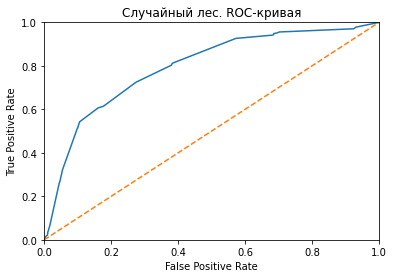

AUC-ROC: 0.794576548813837
f1 : 0.5400516795865633


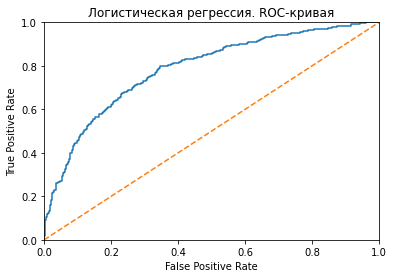

AUC-ROC: 0.7860371928168539
f1 : 0.3333333333333333


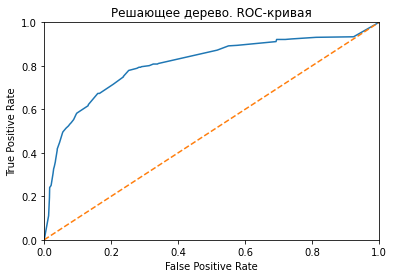

AUC-ROC: 0.8081694946101727
f1 : 0.5763688760806917


In [36]:
roc_plot(model_RF_1, features_train, target_train, features_val, target_val, \
         'Случайный лес. ', 'f1', f1_RF_1)
roc_plot(model_LR_1, features_train, target_train, features_val, target_val, \
         'Логистическая регрессия. ', 'f1', f1_LR_1)
roc_plot(model_DT_1, features_train, target_train, features_val, target_val, \
         'Решающее дерево. ', 'f1', f1_DT_1)

Лучшей по метрикам f1 и AUC-ROC является модель случайного леса:

- f1 лучшей модели: 0.5732484076433121
- количество деревьев лучшей модели: 39
- максимальная глубина дерева лучшей модели: 20

F1-мера меньше 0.59, задача не выполнена.

# 3. Борьба с дисбалансом <a class="anchor" id="chapter3"></a>

## 3.1. Взвешивание классов <a class="anchor" id="section_3_1"></a>

Укажем `class_weight='balanced'`, чтобы алгоритм посчитал, во сколько раз класс «0» встречается чаще класса «1» и присвоил больший вес редкому классу.

In [37]:
%%time
model_RF_2, f1_RF_2 = best_model_on_metric('RandomForestClassifier',
                                features_train, 
                                target_train, 
                                features_val, 
                                target_val, 
                                'f1',
                                n_estimators=20, 
                                max_depth=10,
                                class_weight='balanced')

f1 лучшей модели: 0.64
количество деревьев лучшей модели: 162
максимальная глубина дерева лучшей модели: 9
Wall time: 1min 42s


In [38]:
%%time
model_LR_2, f1_LR_2 = best_model_on_metric('LogisticRegression',
                                       features_train, 
                                       target_train, 
                                       features_val, 
                                       target_val, 
                                       'f1',
                                       class_weight='balanced'
                                      )

f1 лучшей модели: 0.5215889464594127
Wall time: 28.5 ms


In [39]:
%%time
model_DT_2, f1_DT_2 = best_model_on_metric('DecisionTreeClassifier',
                                features_train, 
                                target_train, 
                                features_val, 
                                target_val, 
                                'f1',
                                max_depth=100,
                                class_weight='balanced')

f1 лучшей модели: 0.5735159817351598
максимальная глубина дерева лучшей модели: 7
Wall time: 3.54 s


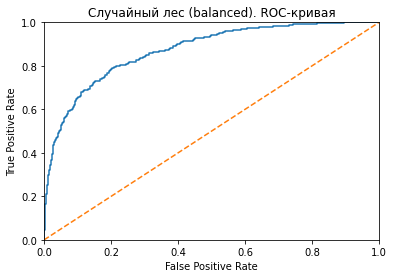

AUC-ROC: 0.8719058041091939
f1 : 0.64


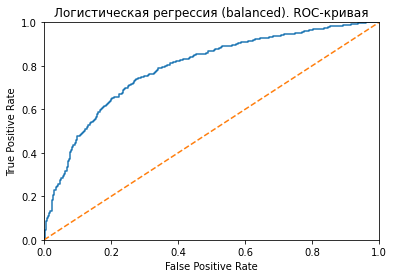

AUC-ROC: 0.7904530107919939
f1 : 0.5215889464594127


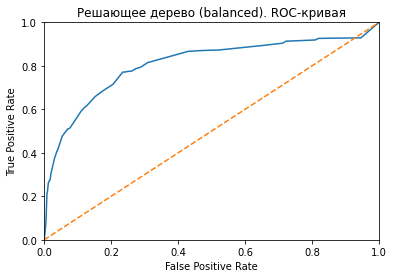

AUC-ROC: 0.8085712831475544
f1 : 0.5735159817351598


In [40]:
roc_plot(model_RF_2, features_train, target_train, features_val, target_val, \
         "Случайный лес (balanced). ", 'f1', f1_RF_2)
roc_plot(model_LR_2, features_train, target_train, features_val, target_val, \
         "Логистическая регрессия (balanced). ", 'f1', f1_LR_2)
roc_plot(model_DT_2, features_train, target_train, features_val, target_val, \
         "Решающее дерево (balanced). ", 'f1', f1_DT_2)

Все модели показали более лучшие результаты, чем в предыдущем эксперименте. Модель случайного леса решает поставленную задачу (F1 > 0.59):
- f1 лучшей модели: 0.608
- количество деревьев лучшей модели: 22
- максимальная глубина дерева лучшей модели: 12
- Wall time: 2min 6s

Единственный недочет - время обучения.

## 3.2. Увеличение выборки <a class="anchor" id="section_3_2"></a>

Посчитаем количество объектов каждого класса.

In [41]:
features_zeros = features_train[target_train == 0] 
features_ones  = features_train[target_train == 1] 
target_zeros = target_train[target_train == 0] 
target_ones  = target_train[target_train == 1] 

print('Количество объектов для признаков отрицательного класса:', features_zeros.shape[0])
print('Количество объектов для признаков положительнгого класса:',features_ones.shape[0])
print('Количество объектов для целей отрицательного класса:',target_zeros.shape[0])
print('Количество объектов для целей положительнгого класса:',target_ones.shape[0])

Количество объектов для признаков отрицательного класса: 4777
Количество объектов для признаков положительнгого класса: 1223
Количество объектов для целей отрицательного класса: 4777
Количество объектов для целей положительнгого класса: 1223


Объектов положительного класса примерно в 4 раза меньше объектов отрицательного класса. Увеличим количество объектов положительного класса  так, чтобы оно было примерно равно количеству объектов отрицательного класса.

In [42]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0] #  признаки объектов с ответом «0»;
    features_ones = features[target == 1] # признаки объектов с ответом «1»;
    target_zeros = target[target == 0] # целевой признак объектов, у которых ответы только «0»;
    repeat = repeat # количество повторений
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(
    features_upsampled, target_upsampled, random_state=12345) # перемешиваем данные
    return features_upsampled, target_upsampled

In [43]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

print(features_upsampled.shape)
print(target_upsampled.shape)

(9669, 21)
(9669,)


In [44]:
%%time
model_RF_3, f1_RF_3 = best_model_on_metric('RandomForestClassifier',
                                features_upsampled, 
                                target_upsampled, 
                                features_val, 
                                target_val, 
                                'f1',
                                n_estimators=20, 
                                max_depth=10,
                                class_weight='balanced')

f1 лучшей модели: 0.6350210970464134
количество деревьев лучшей модели: 483
максимальная глубина дерева лучшей модели: 9
Wall time: 2min 22s


In [45]:
%%time
model_LR_3, f1_LR_3 = best_model_on_metric('LogisticRegression',
                                        features_upsampled, 
                                        target_upsampled, 
                                        features_val, 
                                        target_val, 
                                        'f1',
                                        class_weight='balanced')

f1 лучшей модели: 0.5215889464594127
Wall time: 48.3 ms


In [46]:
%%time
model_DT_3, f1_DT_3 = best_model_on_metric('DecisionTreeClassifier',
                                features_upsampled, 
                                target_upsampled, 
                                features_val, 
                                target_val, 
                                'f1',
                                max_depth=100,
                                class_weight='balanced')

f1 лучшей модели: 0.5722120658135283
максимальная глубина дерева лучшей модели: 7
Wall time: 4.73 s


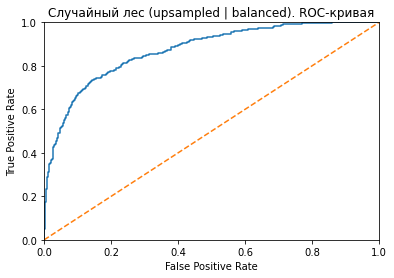

AUC-ROC: 0.872294482463974
f1 : 0.6350210970464134


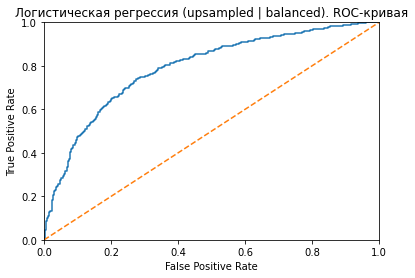

AUC-ROC: 0.7903990276871633
f1 : 0.5215889464594127


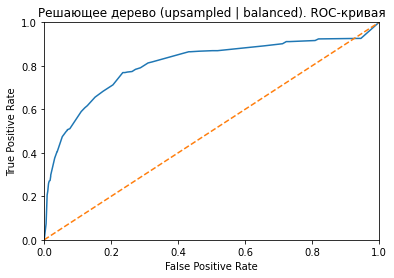

AUC-ROC: 0.8060495009647551
f1 : 0.5722120658135283


In [47]:
roc_plot(model_RF_3, features_upsampled, target_upsampled, features_val, target_val, \
         "Случайный лес (upsampled | balanced). ", 'f1', f1_RF_3)
roc_plot(model_LR_3, features_upsampled, target_upsampled, features_val, target_val, \
         "Логистическая регрессия (upsampled | balanced). ", 'f1', f1_LR_3)
roc_plot(model_DT_3, features_upsampled, target_upsampled, features_val, target_val, \
         "Решающее дерево (upsampled | balanced). ", 'f1', f1_DT_3)

## 3.3. Изменение порога классификации <a class="anchor" id="section_3_3"></a>

Посмотрим, удастся ли добиться лучших результатов F1, если изменить порог классификации в различных моделях.

In [48]:
%%time
model_RF_4, f1_RF_4 = best_model_on_metric('RandomForestClassifier',
                                features_upsampled, 
                                target_upsampled, 
                                features_val, 
                                target_val, 
                                'f1',
                                n_estimators=20, 
                                max_depth=10,
                                class_weight='balanced',
                                method='predict_proba')

f1 лучшей модели: 0.6556213017751479
количество деревьев лучшей модели: 54
максимальная глубина дерева лучшей модели: 8
вероятность класса 1 для модели с лучшей f1 : 0.56
Wall time: 2min 47s


In [49]:
%%time
model_LR_4, f1_LR_4 = best_model_on_metric('LogisticRegression',
                                        features_upsampled, 
                                        target_upsampled, 
                                        features_val, 
                                        target_val, 
                                        'f1',
                                        class_weight='balanced',
                                        method='predict_proba')

f1 лучшей модели: 0.530938123752495
вероятность класса 1 для модели с лучшей f1 : 0.56
Wall time: 212 ms


In [50]:
%%time
model_DT_4, f1_DT_4 = best_model_on_metric('DecisionTreeClassifier',
                                features_upsampled, 
                                target_upsampled, 
                                features_val, 
                                target_val, 
                                'f1',
                                max_depth=100,
                                class_weight='balanced',
                                method='predict_proba')

f1 лучшей модели: 0.5917525773195876
максимальная глубина дерева лучшей модели: 6
вероятность класса 1 для модели с лучшей f1 : 0.6
Wall time: 16.3 s


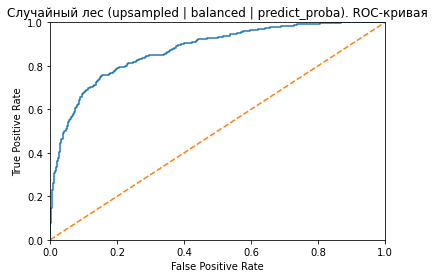

AUC-ROC: 0.8730456188083306
f1 : 0.6556213017751479


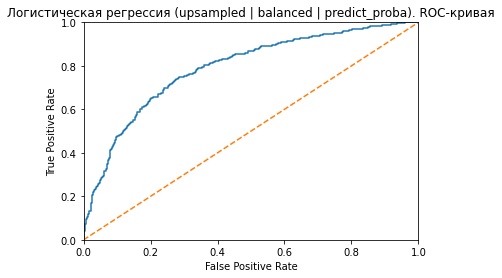

AUC-ROC: 0.7903990276871633
f1 : 0.530938123752495


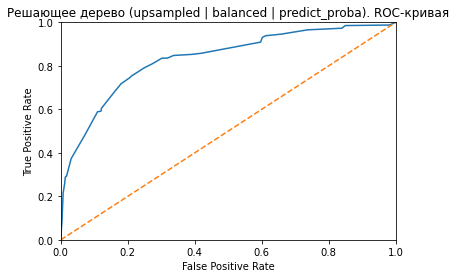

AUC-ROC: 0.8337212405009015
f1 : 0.5917525773195876


In [51]:
roc_plot(model_RF_4, features_upsampled, target_upsampled, features_val, target_val, \
         "Случайный лес (upsampled | balanced | predict_proba). ", 'f1', f1_RF_4)
roc_plot(model_LR_4, features_upsampled, target_upsampled, features_val, target_val, \
         "Логистическая регрессия (upsampled | balanced | predict_proba). ", 'f1', f1_LR_4)
roc_plot(model_DT_4, features_upsampled, target_upsampled, features_val, target_val, \
         "Решающее дерево (upsampled | balanced | predict_proba). ", 'f1', f1_DT_4)

И, напоследок, попробуем метод 'predict_proba' для моделей не по увеличенной выборке:

In [56]:
%%time
model_RF_5, f1_RF_5 = best_model_on_metric('RandomForestClassifier',
                                features_train, 
                                target_train, 
                                features_val, 
                                target_val, 
                                'f1',
                                n_estimators=20, 
                                max_depth=10,
                                class_weight='balanced',
                                method='predict_proba')

f1 лучшей модели: 0.6496350364963503
количество деревьев лучшей модели: 483
максимальная глубина дерева лучшей модели: 8
вероятность класса 1 для модели с лучшей f1 : 0.54
Wall time: 2min 8s


In [53]:
%%time
model_LR_5, f1_LR_5 = best_model_on_metric('LogisticRegression',
                                        features_train, 
                                        target_train, 
                                        features_val, 
                                        target_val, 
                                        'f1',
                                        class_weight='balanced',
                                        method='predict_proba')

f1 лучшей модели: 0.530938123752495
вероятность класса 1 для модели с лучшей f1 : 0.56
Wall time: 190 ms


In [54]:
%%time
model_DT_5, f1_DT_5 = best_model_on_metric('DecisionTreeClassifier',
                                features_train, 
                                target_train, 
                                features_val, 
                                target_val, 
                                'f1',
                                max_depth=100,
                                class_weight='balanced',
                                method='predict_proba')

f1 лучшей модели: 0.5911431513903191
максимальная глубина дерева лучшей модели: 6
вероятность класса 1 для модели с лучшей f1 : 0.6
Wall time: 15.3 s


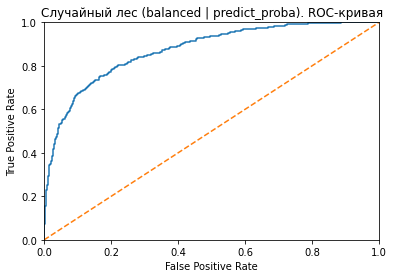

AUC-ROC: 0.8729361102242459
f1 : 0.6496350364963503


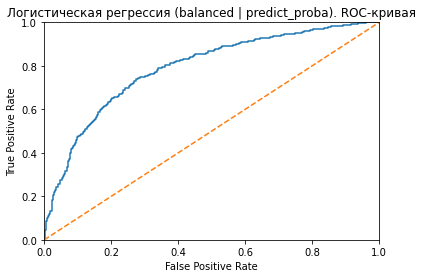

AUC-ROC: 0.7903990276871633
f1 : 0.530938123752495


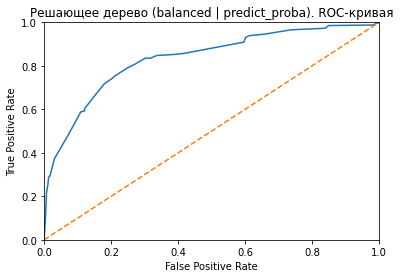

AUC-ROC: 0.8337212405009015
f1 : 0.5911431513903191


In [57]:
roc_plot(model_RF_5, features_upsampled, target_upsampled, features_val, target_val, \
         "Случайный лес (balanced | predict_proba). ", 'f1', f1_RF_5)
roc_plot(model_LR_5, features_upsampled, target_upsampled, features_val, target_val, \
         "Логистическая регрессия (balanced | predict_proba). ", 'f1', f1_LR_5)
roc_plot(model_DT_5, features_upsampled, target_upsampled, features_val, target_val, \
         "Решающее дерево (balanced | predict_proba). ", 'f1', f1_DT_5)

На валидационной выборке лучше всего результаты получились, если увеличить выборку, сбалансировать классы и поиграться с порогом классификации - модель `model_RF_4`.

# 4. Тестирование модели <a class="anchor" id="chapter4"></a>

Поместим результаты предсказаний наших трёх моделей в переменные.

In [73]:
model_RF_4_predictions = model_RF_4.predict(features_test)
#model_LR_4_predictions = model_LR_4.predict(features_test)
#model_DT_4_predictions = model_DT_4.predict(features_test)

In [74]:
# Функция для подсчёта ошибочных предсказаний
def error_count(answers, predictions):
    errors = 0
    for row in range(0, len(predictions)):
        if answers[row] != predictions[row]:
                     errors += 1
    return errors

In [75]:
# Функция для подсчёта доли правильных ответов
def accuracy(answers, predictions):
    accuracy = (len(answers) - error_count(answers, predictions))/len(answers)
    return accuracy

In [76]:
def check_models(test_target, test_predictions, model_name):
    print(model_name, "Errors:",error_count(test_target.reset_index(drop=True), test_predictions))
    print(model_name, "Accuracy:", accuracy(test_target.reset_index(drop=True), test_predictions))

Посмотрим на количество ошибок и точность по итогам тестирования разных моделей:

In [77]:
check_models(target_test, model_RF_4_predictions, 'Best Forest')

Best Forest Errors: 372
Best Forest Accuracy: 0.814


In [63]:
#check_models(target_test, model_LR_4_predictions, 'Logistic Regression')

Logistic Regression Errors: 583
Logistic Regression Accuracy: 0.7085


In [64]:
#check_models(target_test, model_DT_4_predictions, 'Best Tree')

Best Tree Errors: 487
Best Tree Accuracy: 0.7565


Посмотрим, какие значения F1 получатся на тестовой выборке для различных моделей.

In [78]:
aprf1('f1', target_test, model_RF_4_predictions)

0.6204081632653061

In [66]:
#aprf1('f1', target_test, model_LR_4_predictions)

0.507185122569738

In [67]:
#aprf1('f1', target_test, model_DT_4_predictions)

0.5671111111111111

# Итог <a class="anchor" id="chapter5"></a>

Нам удалось получить F1 > 0.59 для нескольких моделей случайного леса с разными параметрами. Победила модель `model_RF_4`.